This notebook tests that required modules can be imported. It also contains a few examples of the functions in `common.py` to initialize the fields, and calculations of the theoretical peaks that will be used in the following notebooks.

# Testing the setup

In [1]:
import os
# Remove warning when importing Taichi due to old glibc
os.environ["TI_MANYLINUX2014_OK"] = "1"
import time
import numpy
import numba
import numexpr
import taichi
import matplotlib
import gt4py

# Initializing fields

In [2]:
from common import initialize_field, plot_field, save_result, compare_results

In [3]:
NX = 128
NY = 128
NZ = 80

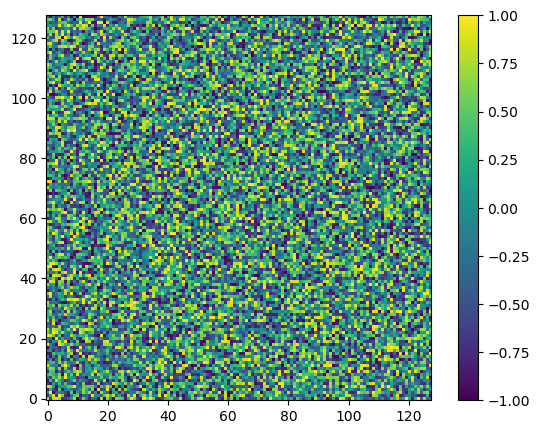

In [4]:
field = initialize_field(NX, NY, NZ, mode="random")
plot_field(field)

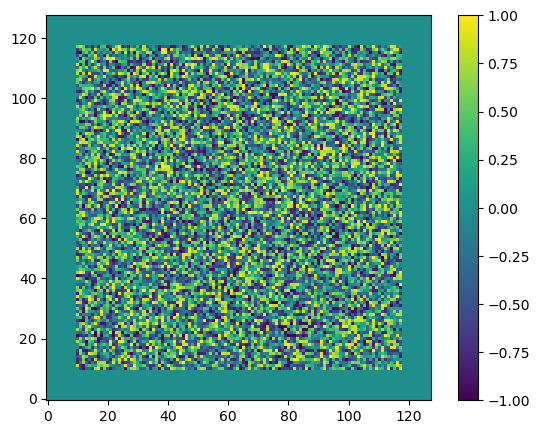

In [5]:
field = initialize_field(NX, NY, NZ, mode="random", num_halo=10)
plot_field(field)

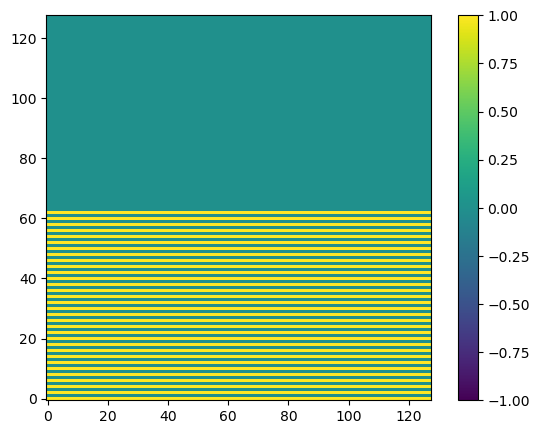

In [6]:
field = initialize_field(NX, NY, NZ, mode="horizontal-bars")
plot_field(field)

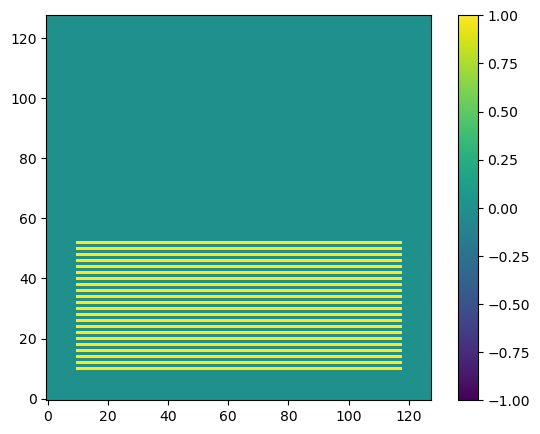

In [7]:
field = initialize_field(NX, NY, NZ, mode="horizontal-bars", num_halo=10)
plot_field(field)

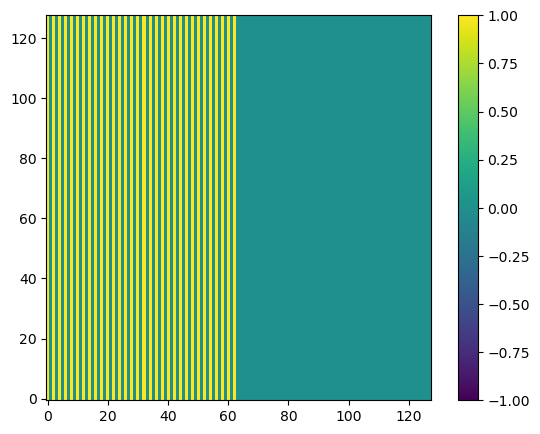

In [8]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
plot_field(field)

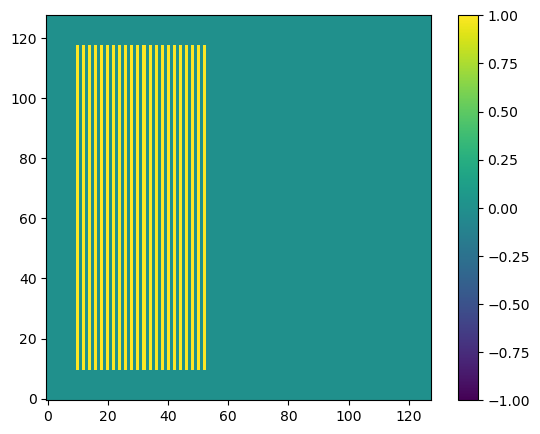

In [9]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars", num_halo=10)
plot_field(field)

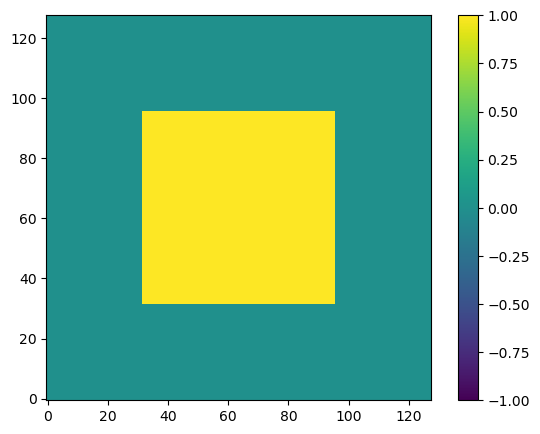

In [10]:
field = initialize_field(NX, NY, NZ, mode="square")
plot_field(field)

The underlying order of the dimensions in the NumPy arrays can be changed to any of the 6 possible permutations by using the kwarg `dim_order`. Plotting the field will still work as expected if we use the same kwarg there.

(80, 128, 128)

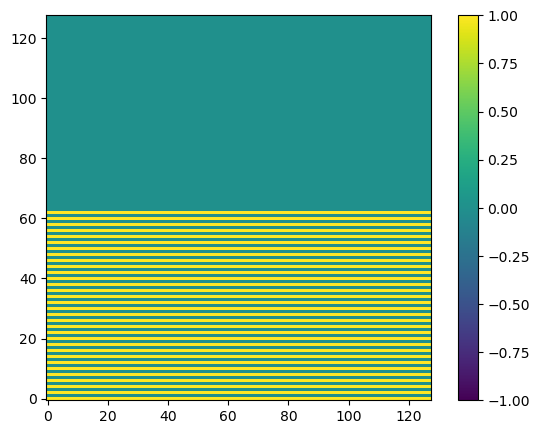

In [11]:
dim_order = "ZXY"
field = initialize_field(NX, NY, NZ, dim_order=dim_order, mode="horizontal-bars")
plot_field(field, dim_order=dim_order)
field.shape

(128, 80, 128)

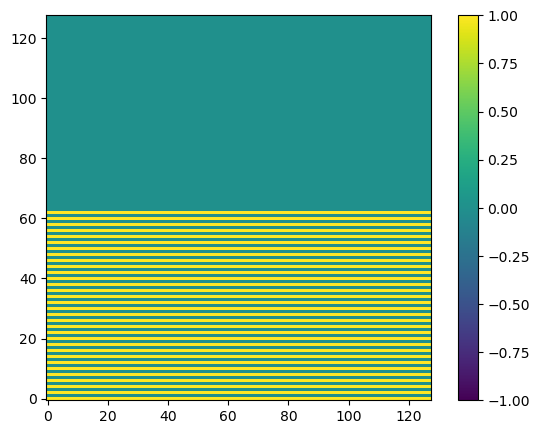

In [12]:
dim_order = "YZX"
field = initialize_field(NX, NY, NZ, dim_order=dim_order, mode="horizontal-bars")
plot_field(field, dim_order=dim_order)
field.shape

# Benchmarking in Jupyter


### Measuring running times

Since we will be working with Python code all the project, we will run all the tests, examples and benchmarks in Jupyter notebooks. In order to measure benchmark we will use the built-in magic commands `%timeit` and`%%timeit`.

According to [the IPython documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)

> In cell mode, the statement in the first line is used as setup code (executed but not timed) and the body of the cell is timed. The cell body has access to any variables created in the setup code.

Let's quickly verify this

In [13]:
%%timeit
1 + 1

4.46 ns ± 0.0455 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [14]:
%%timeit
time.sleep(1)  # This line is executed and measured
1 + 1

1 s ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit time.sleep(1)  # This line is executed but not measured
1 + 1

4.55 ns ± 0.0642 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


For slow cells (>5s) we will limit the number of repetitions to just 3 using `%%timeit -n1 -r3`

In [16]:
%%timeit -n1 -r3
time.sleep(3)  # By default, %%timeit would repeat this cell 7 times

3 s ± 5.42 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


The output of the magic command can be saved to a variable using the other built-in magic command `%capture`

In [17]:
%%capture result
%%timeit -n1 -r3
time.sleep(3)

In [18]:
print(type(result))
print(result)

<class 'IPython.utils.capture.CapturedIO'>
3 s +- 44.7 us per loop (mean +- std. dev. of 3 runs, 1 loop each)



However, it is more useful, to store the output as a `TimeitResult`, so that we can access the avergage and standard deviation values as floats.

In [19]:
%%timeit -n1 -r3 -o
time.sleep(3)

3 s ± 45.2 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 3 s ± 45.2 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [20]:
result = _

In [21]:
print(type(result))
print(result.average)
print(result.stdev)

<class 'IPython.core.magics.execution.TimeitResult'>
3.0001444080001725
4.5164323411323414e-05


### Saving results

In order to automatize saving the benchmark results we have written the function `save_result()`. The first time we call the function, or if we want to overwrite previous results we can pass `overwrite=True` and `header=True`. Later, we can ommit them and new results will be appended at the end of the file.

In [22]:
save_result(result, "test_3s_sleep", overwrite=True, header=True)

In [23]:
save_result(result, "test_3s_sleep_bis")

In [24]:
!cat results.csv

timestamp,function,hardware,timeit_avg,timeit_std
2023-08-24 09:22:26.249158,test_3s_sleep,thinkpad,3.00e+00,4.52e-05
2023-08-24 09:22:26.258240,test_3s_sleep_bis,thinkpad,3.00e+00,4.52e-05


Let's clean the file and just add the header

In [25]:
save_result(None, overwrite=True, header=True)

In [26]:
!cat results.csv

timestamp,function,hardware,timeit_avg,timeit_std


### Comparing results

To avoid confusion about expressions like *"A is x times faster than B"*, "B is y times slower than A", or *"A is z % slower than B"*, in all our notebooks we will only use these two expressions to compare benchmarking times: 

A is x times as fast as B, i.e., $B = xA$, and

A is x % faster than B, i.e., $B - A = \dfrac{xA}{100}$

Example: computing a stencil takes 15.3 seconds on a laptop (A) and 6.5 on a desktop (B)

In [27]:
A = 15.3
B = 6.5

print(f'The desktop is {compare_results(B, A, "faster")} times as fast as the laptop')
print(f'The desktop is {compare_results(B, A, "faster-%")} faster than the laptop')

The desktop is ~2.4 times as fast as the laptop
The desktop is ~135% faster than the laptop


Example: A = 42 ms and B = 1.07 s

In [28]:
A = 42e-3
B = 1.07

print(f'A is {compare_results(A, B, "faster")} times as fast as B')
print(f'A is {compare_results(A, B, "faster-%")} faster than B')

A is ~25.5 times as fast as B
A is ~2448% faster than B


In [29]:
A = 42e-3
B = 58e-3

print(f'A is {compare_results(A, B, "faster")} times as fast as B')
print(f'A is {compare_results(A, B, "faster-%")} faster than B')

A is ~1.4 times as fast as B
A is ~38% faster than B


# Theoretical peaks

TODO